# Modelling and Evaluation Part 2

## Objectives

- Create a Sigmoid output model to predict if a cherry leaf is infected with powdery mildew, which is the primary Business Requirement
- A Softmax model has been created already with an accuracy of 99.64%, the goal is to see if a different Sigmoid model can outperform it

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test
Each folder has 2 subfolders: 'healthy' and 'powdery_mildew'
- image_shape pkl [pickle] file


## Outputs

- Image distribution plot, train vs validation vs test
- Class_indices.pkl
- Machine learning model creation and training (mildew_detection_model)
- evaluation.pkl
- Plotting model performance, model_training_acc.png, model_training_losses.png
<!-- - validation_set_confusion_matrix.png, test_set_confusion_matrix.png -->
- Prediction on selected image files

## Install dependencies

In [1]:
pip install -r /workspace/mildew-detection/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread



## Change working directory

Change working directory from current to parent folder.

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

In [4]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [6]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [7]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version if required.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version if required.


## Set label names

In [8]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(80, 80, 3)

## Image augmentation (Sigmoid)

ImageDataGenerator will be used to augment the image pool as the data is loaded

As class_mode is different when augmenting for Sigmoid vs Softmax, this needs to be run again in this notebook

The ImageDataGenerator is imported and initialised

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

And the image pool for each set is augmented to be used in the model

### Train set

In [11]:
batch_size = 32
train_set_2 = augmented_image_data.flow_from_directory(train_dir, # Take images from 'train' folder
                                                    target_size=image_shape[:2], 
                                                    color_mode='rgb',
                                                    batch_size=batch_size, 
                                                    class_mode='binary', # sigmoid activation requires binary
                                                    shuffle=False # Shuffle the images
                                                    )
train_set_2.class_indices  

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Validation set

In [12]:
validation_set_2 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )
validation_set_2.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Test set

In [13]:
test_set_2 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=True
                                                                  )
test_set_2.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Save train set class_indices as a pkl file 

In [14]:
joblib.dump(value=train_set_2.class_indices,
            filename=f"{file_path}/class_indices_2.pkl")

['outputs/v1/class_indices_2.pkl']

## Plot augmented images for each set (showing 2 sample images from each)

### Train set

(32, 80, 80, 3)


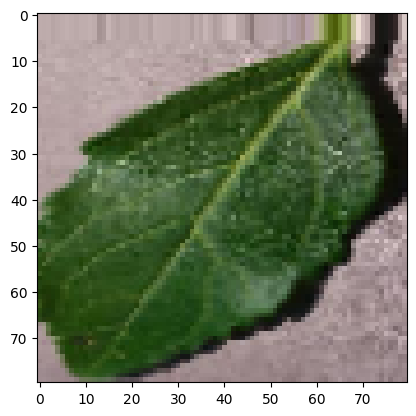

(32, 80, 80, 3)


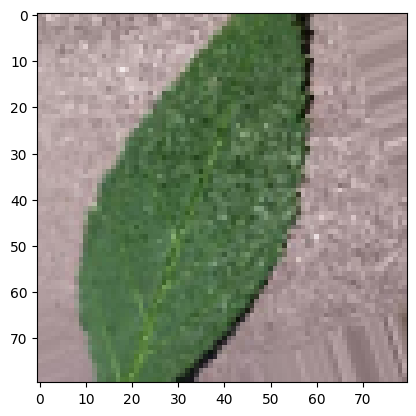

In [15]:
for _ in range(2):
    img, label = train_set_2.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Validation set

(32, 80, 80, 3)


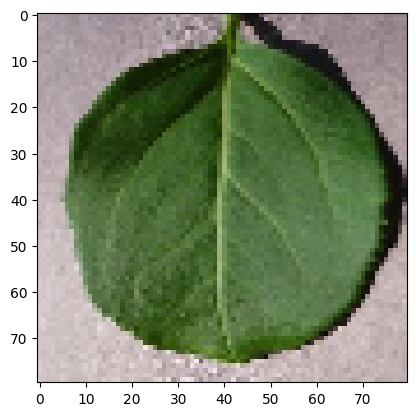

(32, 80, 80, 3)


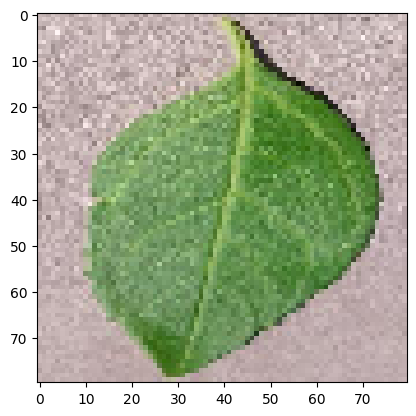

In [16]:
for _ in range(2):
    img, label = validation_set_2.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Test set

(32, 80, 80, 3)


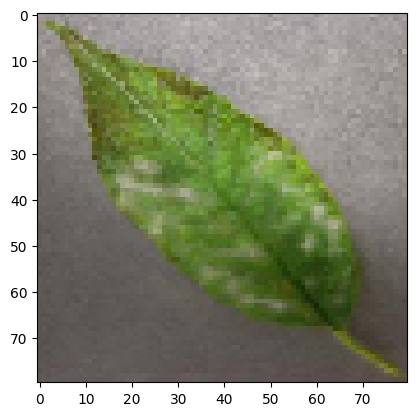

(32, 80, 80, 3)


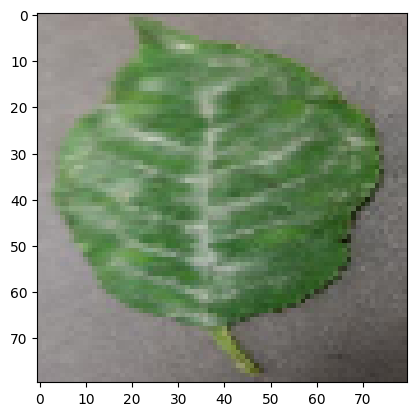

In [17]:
for _ in range(2):
    img, label = test_set_2.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Create sigmoid output model

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LearningRateScheduler

# Initial learning rate
initial_learning_rate = 1e-3

# Learning rate schedule function
def lr_schedule(epoch, learning_rate):
    if epoch < 8:
        return learning_rate  # Initial learning rate for first 8 epochs
    else:
        return learning_rate * tf.math.exp(-0.1)  # Exponentially decay the learning rate each 8 epochs

# learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

def create_model_sig(learning_rate=initial_learning_rate):
    model = Sequential()

    # input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolution layers
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))

    # output
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer=Nadam(learning_rate=learning_rate),
                metrics=['accuracy'])

    return model, lr_scheduler  # return the model and lr_scheduler callback


Show a summary of the sigmoid model

In [19]:
model, _ = create_model_sig()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

2024-03-28 04:48:04.489811: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Early stopping

Early stopping is included to stop the model once it starts to overfit

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

## Fit model for training

In [22]:
model, lr_scheduler = create_model_sig()
lr_scheduler = LearningRateScheduler(lr_schedule)

model.fit(train_set_2, epochs=40, 
        steps_per_epoch=len(train_set_2.classes) // batch_size,
        validation_data=validation_set_2,
        callbacks=[early_stop, lr_scheduler],
        verbose=1
        )

Epoch 1/40
12/92 [==>...........................] - ETA: 30s - loss: 0.7860 - accuracy: 0.4740

92/92 [==============================] - 24s 255ms/step - loss: 0.7569 - accuracy: 0.4976 - val_loss: 0.6854 - val_accuracy: 0.5000
Epoch 2/40
92/92 [==============================] - 17s 187ms/step - loss: 0.6977 - accuracy: 0.5071 - val_loss: 0.6804 - val_accuracy: 0.7667
Epoch 3/40
92/92 [==============================] - 17s 190ms/step - loss: 0.7484 - accuracy: 0.6770 - val_loss: 1.2741 - val_accuracy: 0.5833
Epoch 4/40
92/92 [==============================] - 17s 189ms/step - loss: 0.7222 - accuracy: 0.7721 - val_loss: 0.3093 - val_accuracy: 0.9024
Epoch 5/40
92/92 [==============================] - 17s 185ms/step - loss: 0.2765 - accuracy: 0.8865 - val_loss: 0.0702 - val_accuracy: 0.9690
Epoch 6/40
92/92 [==============================] - 17s 182ms/step - loss: 0.1437 - accuracy: 0.9545 - val_loss: 0.0678 - val_accuracy: 0.9762
Epoch 7/40
92/92 [==============================] - 17s 189ms/step - loss: 0.1104 - accuracy: 0.9630 - val_loss: 0.0362 - val_accuracy: 0.9881
Epoch 8/40

## Save the model

In [23]:
model.save('outputs/v1/mildew_detection_model_2.h5')

# Sigmoid model performance

## Model learning curve

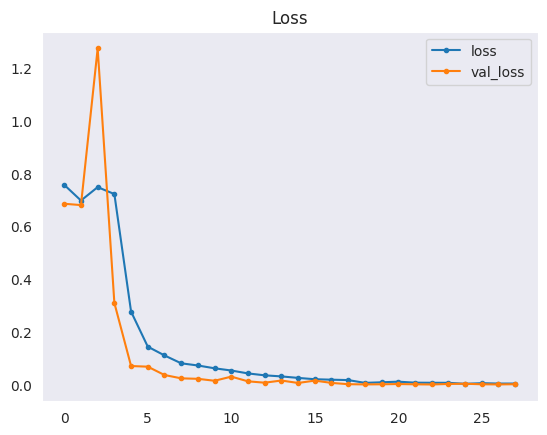

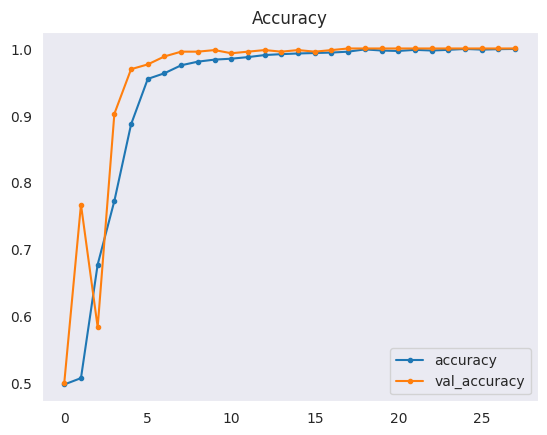

In [24]:
losses = pd.DataFrame(model.history.history)

sns.set_style("dark")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses_sigmoid.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc_sigmoid.png', bbox_inches='tight', dpi=150)
plt.show()

## Model evaluation

Load saved model

In [25]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detection_model_2.h5')

Check model performance on test set

In [26]:
evaluation = model.evaluate(test_set_2, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: {:.4f}%".format(evaluation[0]))

11/27 [===========>..................] - ETA: 1s - loss: 0.0033 - accuracy: 0.9972    

27/27 [==============================] - 2s 85ms/step - loss: 0.0044 - accuracy: 0.9976
Model accuracy: 99.76%
Model Loss: 0.0044%


The model performs with over 99.7% accuracy, easily meeting the business requirement of 97%

Save evaluation pkl file

In [27]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation_sigmoid.pkl")

['outputs/v1/evaluation_sigmoid.pkl']

## Predict on new data

An image from the 'healthy' label is fed into the model to randomly check accuracy

Image shape: (80, 80), Image mode: RGB


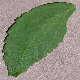

In [28]:
from tensorflow.keras.preprocessing import image
import random

label = labels[0]  # label '0' = 'healthy'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to an array for prediction

In [29]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


The prediction is run

In [30]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set_2.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.9999751294380985
healthy


The steps above are repeated for a random infected image as a second check

Image shape: (80, 80), Image mode: RGB


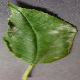

In [31]:
from tensorflow.keras.preprocessing import image
import random

label = labels[1]  # label '1' = 'powdery_mildew'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [32]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


In [33]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set_2.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.9999334
powdery_mildew


Show contents of .gitignore

In [34]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

# Conclusions

- A Sigmoid model was created and the parameters/hyperparameters tuned using different numbers of nodes, loss metrics, epochs and optimizers and learning rate schedules and emerged as very accurate (>99%)
- The Sigmoid model outperforms the Softmax model from the previous notebook, so this Sigmoid model is the model I'll use in the final version presented to the client
- A larger dataset, as well as further tuning of hyperparameters may help to refine accuracy somewhat, though the model already performs far above the required 97% - there's not a lot of room to improve further. Image size has also been reduced to 80 by 80 - larger images would give more information for the model at the expense of the size of the final deployment

## Next steps

- A Streamlit Dashboard will be constructed to fulfil Business Requirement 2